In [195]:
import numpy as np
from PIL import Image
import PIL
import cv2
from pdf2image import convert_from_path
import math
import string
import json as j
import io
from google.cloud import vision_v1
import sys
import matplotlib.pyplot as plt
%matplotlib notebook



def boundary(image):
    if isinstance(image,PIL.PpmImagePlugin.PpmImageFile):
        image = np.array(image)
    r,c,_ = image.shape
    image = cv2.line(image,(0,0),(0,r),(255,255,255),30)
    image = cv2.line(image,(0,0),(c,0),(255,255,255),30)
    image = cv2.line(image,(0,int(r*0.8409)),(c,int(r*0.8409)),(255,255,255),30)
    image = cv2.line(image,(c,0),(c,r),(255,255,255),30)
    
    image = image[:(int(r*0.8409)),:]
#     plt.imshow(image)
#     return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 160,255,cv2.THRESH_BINARY_INV)[1]
    gray = np.float32(thresh)
#     plt.imshow(blurred)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
#     dst = cv.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
#     image[dst>0.01*dst.max()]=[0,0,255]
#     plt.imshow(image)
    indices = np.argwhere((dst>0.01*dst.max()) == True)
    distances = np.linalg.norm(indices,axis = 1)
    sorted_distances = sorted(distances)
#     print(distances)
    start = indices[np.where(distances == sorted_distances[0] )[0][0],:]
    end = indices[np.where(distances == sorted_distances[-1] )[0][0],:]
#     print( )
#     print( )
    
#     image[dst>0.01*dst.max()]=[0,0,255]
    
    image = image[start[0]:end[0],start[1]:end[1]]
#     plt.imshow(image)
    return image

def detect(sec,path):
    file_path = path+".tiff"
    cv2.imwrite(file_path,sec)
    client = vision_v1.ImageAnnotatorClient()
    mime_type = "image/tiff"
    with io.open(file_path, "rb") as f:
        content = f.read()
    input_config = {"mime_type": mime_type, "content": content}
    features = [{"type_": vision_v1.Feature.Type.DOCUMENT_TEXT_DETECTION}]

    # The service can process up to 5 pages per document file. Here we specify
    # the first, second, and last page of the document to be processed.
    pages = [1, 2, -1]
    requests = [{"input_config": input_config, "features": features, "pages": pages}]

    response = client.batch_annotate_files(requests=requests)
    LIST = []
    for image_response in response.responses[0].responses:
        for page in image_response.full_text_annotation.pages:
            for block in page.blocks:
                for par in block.paragraphs:
                    for word in par.words:
                        wor = []
                        for symbol in word.symbols:
                            wor.append(symbol.text)
                        LIST.append( ( [[v.x,v.y] for v in word.bounding_box.vertices],"".join(wor)) )
    return LIST


def blockIsIn(block,v):
    for x in block:
        if not isIn(x,v):
            return False
    return True

def isIn(p,v):
    return p[0]>v[0][0]-5 and p[0]<v[1][0]+5 and p[1]>v[0][1]-5 and p[1]<v[1][1]+5

def BreakPoints(a,adjust,x,total = None):
    r,c,_ = a.shape
    breakpoints = []
    breakpoints.append(0)
    change = False
    for row in range(0,a.shape[0]):
#         print(row)
        if a[row,x,0] == 255:
            change = True
            
        if change and a[row,x,0] == 0:
            breakpoints.append(row-adjust)
            change = False
            if total is not None and len(breakpoints) == total:
                break
#     del breakpoints[0]
#     breakpoints.insert(0,0)
    return breakpoints   

# def segmentation(a):
#     f = a.copy()
#     a = cv2.blur(a , (10,3))
#     a = np.where(a < 200 , 0,255)
#     a = np.float32(a)
#     r,c,_ = a.shape
#     plt.imshow(a)
#     hlist = [BreakPoints(a,0,x) for x in range(0,c,10)]
#     breakpoints = sorted(hlist, key = lambda x: len(x), reverse = True)[0]
#     breakpoints.append(r)
# #     print(breakpoints)
#     sections = []
#     for ind in range(len(breakpoints)-1):
#         prevp = breakpoints[ind]
#         nextp = breakpoints[ind+1]
#         if abs(prevp-nextp) > 100:
#             sections.append(f[prevp:nextp,0:c])
# #     for x in sections:
# #         print(x.shape)
#     return sections,breakpoints,a

def segmentation(a,d):
    r,c,_ = a.shape
    img = a.copy()
    img = cv2.blur(img , (10,3))
    img = np.where(img < 200 , 0,255)
    img = np.float32(img)
#     plt.imshow(img)
    
    l = []
    for x in range(0,img[:,1200,0].shape[0]-60):
        l.append(( (img[x:x+d,1200,0]/255).sum() , x))
    sort = sorted(l,key = lambda x: x[0],reverse = False)
    pts = [0]
    def toadd(pts,pt):
        for x in pts:
            if abs(pt-x) < 100:
                return False
        return True
    for (s,x) in sort:
        if toadd(pts,x) and s < 10:
            pts.append(x)
    breakpoints = sorted(pts)
    breakpoints.append(r)
    sections = []
    for ind in range(len(breakpoints)-1):
        prevp = breakpoints[ind]
        nextp = breakpoints[ind+1]
        if abs(prevp-nextp) > 100:
            sections.append(a[prevp:nextp,0:c])
    return sections,breakpoints




def draw(img,cords):
    r,c,_ = img.shape
    for (a,b) in cords:        
        img = cv2.circle(img,a,5,(255,0,0),-1)
        img = cv2.circle(img,b,5,(0,0,0),-1)
    plt.imshow(img)

def extractsec1(LIST,c,z):
    RATINGLIST = []
    STATEL = []
    STATE = [(int(0.76*c), int(0.376*z)), (int(0.883*c), int(0.549*z))]
    RISKID = [(int(0.88*c), int(0.173*z)), (int(1*c),int(0.35*z))]
    RATINGEFFECTIVE = [(int(0.279*c), int(0.387*z)), (int(0.371*c), int(0.56*z))]
    PRODUCTION = [(int(0.565*c),int(0.383*z)),(int(0.663*c),int(0.564*z))]
    RISKNAME = [(int(0.193*c), int(0.214*z)), (int(0.632*c),int(0.346*z))]
    STATECODE = [(int(0*c),int(0.719*z)),(int(0.1107*c),int(0.86*z))]
    CARRIER = [(int(0.07*c),int(0.88*z)),(int(0.135*c),int(1*z))]
    EFF_DATE = [(int(0.553*c),int(0.88*z)),(int(0.651*c),int(1*z))]
    EXP_DATE = [(int(0.803*c),int(0.88*z)),(int(0.9*c),int(1*z))]
    POLICYNO = [(int(0.26*c),int(0.88*z)),(int(0.43*c),int(1*z))]
    print(POLICYNO)
    sec1list = [STATE,RISKID,RATINGEFFECTIVE,PRODUCTION,RISKNAME,STATECODE,CARRIER,EFF_DATE,EXP_DATE,POLICYNO]

    RISKLIST = []
    risk_name = ""
    risk_id = ""
    rating_effective_date = ""
    production_date = ""
    state = ""
    state_code = ""
    carrier = ""
    eff = ""
    exp = ""
    pol = ""
    for ind,x in enumerate(LIST):
        if blockIsIn(x[0],RISKID):
            risk_id = x[1]
        if blockIsIn(x[0],RATINGEFFECTIVE):
            RATINGLIST.append(x[1])
        if blockIsIn(x[0],RISKNAME):
            RISKLIST.append(x[1])
        if blockIsIn(x[0],PRODUCTION):
            production_date = x[1]
        if blockIsIn(x[0],STATE):
            state = x[1]            
        if blockIsIn(x[0],STATECODE):
            STATEL.append(x[1])
        if blockIsIn(x[0],CARRIER):
            carrier = x[1]
        if blockIsIn(x[0],EFF_DATE):
            eff = x[1]
        if blockIsIn(x[0],EXP_DATE):
            exp = x[1]
        if blockIsIn(x[0],POLICYNO):
            pol = x[1]
        
        
        
        
        
        
#         if "carrier" in x[1].lower():
#             if ":" in LIST[ind+1][1]:
#                 carrier = LIST[ind+2][1]
#             else:
#                 carrier = LIST[ind+1][1]
#         if "policy" in x[1].lower():
#             if ":" in LIST[ind+1][1]:
#                 policy_no = LIST[ind+2][1]
#             else:
#                 policy_no = LIST[ind+1][1]
    
#     print(rating_effective_date)
#     print(risk_name)
#     print(risk_id)
#     print(production_date)
#     print(state_code)
    rating_effective_date = [x for x in RATINGLIST if ("/" in x)][0]
    risk_name =  " ".join(RISKLIST)
    state_code = " ".join(STATEL)

    if risk_name == "":
        print("Risk Name Not Found")
    if risk_id == "":
        print("Risk ID Not Found")
    if rating_effective_date == "":
        print("Rating Effective Not Found")
    if production_date == "":
        print("Production Date Not Found")
    if state == "":
        print("State Not Found")
    if state_code == "":
        print("State Code Not Found")
    if carrier == "":
        print("Carrier Not Found")
    if eff == "":
        print("Eff Date Not Found")
    if exp == "":
        print("Exp Date Not Found")
    if pol == "":
        print("Policy Number Not Found")
        
    
    
    
    
    
#     return None

    temp = {
                            "risk_name": cleant(risk_name),
                            "risk_id": risk_id,
                            "rating_effective_date": rating_effective_date,
                            "production_date": production_date,
                            "state": state,
                            "carrier": carrier,
                            "policy_no": pol,
                            "eff_date": eff,
                            "exp_date": exp,
                            "code": "",
                            "elr": "",
                            "dratio": "",
                            "payroll": "",
                            "expected_losses": "",
                            "exp_prim_losses": "",
                            "claim_data": "",
                            "ij": "",
                            "of": "",
                            "act_inc_losses": "",
                            "act_prim_losses": "",
                            "statecode": state_code,
                            "Policy Total": "",
                            "Subject Premium": "",
                            "Total Act Inc Losses": ""
                        }
    return temp

def extractsec3(x,data):
    exsec2 = data.copy()
    claim_data = x[6]
    code = x[0]
    try:
        ij = int(x[7])
    except:
        ij = ""
    of = x[8] if len(x[8]) == 1 else ""
    try:
        act_inc_losses = int(x[9].replace(".",",").replace(",",""))
    except:
        act_inc_losses = ""

    try:
        act_prim_losses = int(x[10].replace(".",",").replace(",",""))
    except:
        act_prim_losses = ""

    try:
        payroll = int(x[3].replace(",",""))
    except:
        payroll = ""

    try:
        elr = float(x[1].replace(" ","").replace(",","."))
    except:
        elr = x[1]

    try:
        expected_losses = int(x[4].replace(",",""))
    except:
        expected_losses = ""  

    try:
        dratio = float(x[2].replace(" ","").replace(",","."))
    except:
        dratio = ""

    try:
        exp_prim_losses = int(x[5].replace(",",""))
    except:
        exp_prim_losses = "" 

    exsec2["claim_data"] = claim_data.translate(str.maketrans('', '', '!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))
    exsec2["code"] = code
    exsec2["ij"] = str(ij)
    exsec2["of"] = of
    exsec2["act_inc_losses"] = str(act_inc_losses)
    exsec2["act_prim_losses"] = str(act_prim_losses)
    exsec2["payroll"] = str(payroll)
    exsec2["elr"] = str(elr)
    exsec2["expected_losses"] = expected_losses
    exsec2["dratio"] = str(dratio)
    exsec2["exp_prim_losses"] = exp_prim_losses
    exsec2["claim_data"] = claim_data
        
    return exsec2

def same(P,a,b):
    p = P.copy()
    r , c ,_= p.shape
    rm = 50
    wid = 10
    if c > 2500:
        rm = 100
#         wid = 50
        print("here")
#         a = 300
#         b = 200
#     print(rm,"rm",a,"a",b,"b")
    p = np.where(p < 170 , 0,255)
    a = cv2.blur(p , (a,1))
#     plt.imshow(a)
    a = np.where(a > rm , 255,0)
    
    a = cv2.line(np.float32(a), (0,0), (c, 0), (0, 0, 0), thickness=20)
    plt.imshow(a)
#     print(c)
    hlist = [BreakPoints(a,0,x) for x in range(0,c,10)]
#     print(hlist)
    h = sorted(hlist, key = lambda x: len(x), reverse = True)[0]
    h.append(r)
#     print(h)
    h = hcheck(h)
#     print(h)
    a = cv2.blur(p , (1,b))
    a = np.where(a > rm , 255,0)
    line_thickness = 2
    for x in h:
        a = cv2.line(np.float32(a), (0, x), (c, x), (0, 0, 0), thickness=line_thickness)
    a = cv2.line(a, (0, 0), (0, r), (0, 0, 0), thickness=10)    
    a = cv2.line(a, (c,0), (c, r), (0, 0, 0), thickness=10)
    
    plt.imshow(p)
    yy = []
    cords = []
    y = 0
    ignore_first = False
    for ind in range(1,len(h)):
        temp_cords = []
        temp_yy = []
        mid = int((h[ind] + h[ind-1])/2)
        for x in range(c):
            if a[mid,x].sum() == 0 and ignore_first and abs(y-x) > wid and abs(h[ind] - h[ind-1]) > 20:
                if x < y:
                    y = x
                    continue
                temp_cords.append([(y,h[ind-1]),(x,h[ind])])
                name = np.uint8(P[h[ind-1]:h[ind],y:x,:])
                temp_yy.append(name)
                y = x
            elif a[mid,x].sum() == 0:
                ignore_first = True
        if len(temp_yy) !=0 and len(temp_cords) != 0:
            yy.append(temp_yy)
            cords.append(temp_cords)
    return yy,cords,len(h)

def clean(t):
    return t.translate(str.maketrans('', '', '!"#$%&\'()*+-/:;<=>?@[\\]^_`{|}~')).strip()
def cleant(t):
    return t.translate(str.maketrans('', '', string.punctuation)).strip()


def arrange(array):
    if len(array) == 1:
        return array
    ret = []
    intx = []
    for x in array:
        try:
            ret.append(intx.append(int(x)))
        except:
            ret.append(x)
    return ret
    
def extract3(text_detections_in_order,temp):    
    assert len(text_detections_in_order) <= 4
    for ind , x in enumerate(text_detections_in_order):
        if x != "":
            if ind == 0:
                poltotal = [int(word) for word in cleant(x).split() if word.isdigit()]
            if ind == 1:
                subprem = [int(word) for word in cleant(x).split() if word.isdigit()]
            if ind == 2:
                total_act_inc_loss = [int(word) for word in cleant(x).split() if word.isdigit()]
    try:
        polt = poltotal[0]
    except:
        polt = "0"
        
    try:
        subp = subprem[0]
    except:
        subp = "0"
        
    try:
        totala = total_act_inc_loss[0]
    except:
        totala = "0"
        
                
    
    temp["Policy Total"] = polt
    temp["Subject Premium"] = subp
    temp["Total Act Inc Losses"] = totala
    return temp
    
def extract4(LIST,data,r,b):
    temp = data.copy()
    CARRIER = [(100,r-50+b),(185,r+b)]
    POL = [(337,r-50+b),(500,r+b)]
    EFF = [(723,r-50+b),(853,r+b)]
    EXP = [(1044,r-50+b),(1180,r+b)]
    STATECODE = [(0,r-100+b),(200,r-40+b)]
    pol = ""
    carrier = ""
    eff = ""
    exp = ""
    state_code = ""
    STATEC = []
    
    for ind,x in enumerate(LIST):
        if blockIsIn(x[0],CARRIER):
            carrier = x[1]
        if blockIsIn(x[0],POL):
            pol = x[1]
        if blockIsIn(x[0],EFF):
            eff = x[1]
        if blockIsIn(x[0],EXP):
            exp = x[1]
        if blockIsIn(x[0],STATECODE):
            STATEC.append(x[1])
            
    state_code = "".join(STATEC)
            
    assert isinstance(carrier,str) and len(carrier) > 4
    assert isinstance(pol,str) and len(pol) > 4
    assert isinstance(eff,str) and len(eff) > 4
    assert isinstance(exp,str) and len(exp) > 4
    assert isinstance(state_code,str) and len(state_code) > 4
    
    
    temp["carrier"] = carrier
    temp["policy_no"] = pol
    temp["eff_date"] = eff
    temp["exp_date"] = exp
    temp["statecode"] = state_code
    return temp

def check1(text_detections_row):
    for x in text_detections_row:
        if "total" in x.lower().strip():
            return True
    return False

def hcheck(l):
    newl = [0]
    prev = newl[0]
    for x in range(1,len(l)):
        if abs(prev - l[x]) > 35:
            newl.append(l[x])
            prev = l[x]
    return newl
        

In [170]:
# path = sys.argv[-2]
path = "/home/ramishrasool/Desktop/nirav9033688351-attachments/Ramirashool NCCI PDF task instructions/pdfs/scanned/20210630101336848.pdf"
json = {
            "id": "",
            "document_id": "",
            "remote_id": "",
            "file_name": path.split("/")[-1],
            "media_link": "",
            "media_link_original": "",
            "media_link_data": "",
            "page_count": "",
            "uploaded_at": "",
            "processed_at": "",
            "merged_amit_data_edit": []
}
im = convert_from_path(path)
json["page_count"] = str(len(im))
json

{'id': '',
 'document_id': '',
 'remote_id': '',
 'file_name': '20210630101336848.pdf',
 'media_link': '',
 'media_link_original': '',
 'media_link_data': '',
 'page_count': '4',
 'uploaded_at': '',
 'processed_at': '',
 'merged_amit_data_edit': []}

In [198]:
temp_list = []
for page in range(1,int(json["page_count"])):
#     plt.imshow(im[page])
#     break
    bound = boundary(im[page])
    bound = cv2.cvtColor(bound, cv2.COLOR_RGB2GRAY)
    bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2RGB)
#     bound = cv2.resize(bound, (1300,1670), interpolation = cv2.INTER_AREA)
#     break
#     plt.imshow(bound)
#     break
    
    
    r,c,_ = bound.shape
    if c > 2500:
        print("resizing")
        bound = cv2.resize(bound, (1300,1670), interpolation = cv2.INTER_AREA)
    det = detect(bound,"page"+str(page))
    r,c,_ = bound.shape
#     print(det)
    secs,breakpoints = segmentation(bound,int(r*0.03588516746))
    
    t = extractsec1(det,c,breakpoints[1])
#     break
    print(len(secs),"secs in page",page)

#     print(temp)
    for sec_n in range(1,len(secs)):
        sec = secs[sec_n].copy()
        small_block,cords,hlen = same(sec,int(c*0.03846153846),int(c*0.02307692307))
        print("Sec",sec_n,"of page",page,"has",hlen-1,"rows")
#         plt.imshow(small_block[0][0])
#         break
        text_detections_in_order = []
        for indr,row in enumerate(cords):
            text_detections_row = []
#             print("row",row)
            for indc, ((tlr,tlc),(brr,brc)) in enumerate(row):
                text_detections_col = []
                for ind_d, (block_detection,text) in enumerate(det):
                    if blockIsIn(block_detection,((tlr,tlc+breakpoints[sec_n]),(brr,brc+breakpoints[sec_n]))):
#                         print("text",text,(tlr,tlc),(brr,brc),breakpoints[sec_n],indr,indc,"\tsec",sec_n,"page",page)
                        text_detections_col.append(text)
#                 for x in text_detections_col:
#                     print("x",len(x))
#                 print("appending",text_detections_col)
#                 rearranged = arrange(text_detections_col)
#                 print("rearr",rearranged)

                
                to_add = clean(" ".join(text_detections_col))
#                 print("to_add",to_add)
                text_detections_row.append(to_add)
            if check1(text_detections_row):
                text_detections_in_order.append(text_detections_row)
                break            
            text_detections_in_order.append(text_detections_row)
        print(text_detections_in_order)
        temp = extract3(text_detections_in_order[-1],t)
        for x in range(1,len(text_detections_in_order)-1):
            row = text_detections_in_order[x]
            if len(row) != 11:
                row.insert(2,"")
                row.insert(3,"")
                temp1 = extractsec3(row,temp)
            else:
                temp1 = extractsec3(row,temp)
            temp_list.append(temp1)
        try:
            t = extract4( det,t,sec.shape[0],breakpoints[sec_n]).copy()
        except:
            pass
#         break
#     break
                
print( "Total Records Found:", len(temp_list))
json["merged_amit_data_edit"] = temp_list
json_base = []
json_base.append(json)
# with open("/home/ramishrasool/Desktop/nirav9033688351-attachments/Ramirashool NCCI PDF task instructions/JSONs"+"/"+path.split("/")[-1].split(".")[0]+'.json', 'w') as fp:
#         j.dump(json_base, fp,indent = 4)
# sys.argv[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(338, 238), (559, 271)]
5 secs in page 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 1 of page 1 has 6 rows
[['Code', 'ELR', '', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'IJ', '', '', '', 'Inc', 'Act Prim Losses'], ['3076', '2.56', '.33', '462,378', '11,837', '3,906', 'NO . 3', '06', '', '1,486', '1,486'], ['8810', '.13', '.33', '398,624', '518', '1711', '16007500', '06', 'F', '2,442', '2,442'], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Total  861,002', 'Subject Premium  24,156', 'Total Act Inc Losses  3,928', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 2 of page 1 has 6 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim', '', '13', 'OF', 'Act Inc Losses', 'Act Prim Losses'], ['3076', '2.56', '.33', '1,187,460', '30,399', '10,032', '17003953', '06', 'F', '355', '355'], ['8810', '.13', '.33', '983,718', '1,279', '422', '17000306', '06', 'F', '6,477', '6,477'], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Policy Total  2,171,178', 'Subject Premium  68,412', 'Total Act Inc Losses  6,832', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 3 of page 1 has 6 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', 'OF', 'Act Inc Losses', 'Act Prim Losses'], ['3076', '2.56', '.33', '1,252,978', '32,076', '10,585', 'NO . 2', '06', '', '878', '878'], ['8810', '.13', '.33', '958,165', '1,246', '4111', '18000883', '06', 'F', '4,163', '4,163'], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Policy Total  2,211,143', 'Subject Premium  66,646', 'Total Act Inc Losses  5,041', '']]
Sec 4 of page 1 has 5 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', 'OF', 'Act Inc', 'Act Prim Losses'], ['3076', '2.56', '.33', '1,221,294 31,265', '10,317', 'NO . 2', '06', '', '709', '709'], ['8810', '.13', '.33', '1,129,427', '1,468', '484', '19003428', '06', '', '3,230', '3,230'], ['9812', 'EMPLOYERS LIABILIT', '0', '0 이', '', '', '', '', ''], ['Policy Total  2,350,721', 'Subject Premium  55,483', 'Total Act Inc Losses  3,939', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(338, 239), (559, 272)]
5 secs in page 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 1 of page 2 has 6 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expeeted Losses', 'Exp Prim Losses', 'Claim Data', 'JJ', 'TOF', 'Act Inc Losses', 'Act Prim Losses'], ['8742', '.10', '.33', '105,621', '106', '35', '', '', '', '', ''], ['9807', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['9848', 'MINIMUM PREMIUM FO', '0', '0', '', '', '', '', ''], ['Policy Total  105,621', 'Subject Premium  863', 'Total Act Inc Losses  0', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 2 of page 2 has 6 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected', '', 'Prim', 'Claim Data', '13', 'TOFI', 'Act Inc', 'Act', ''], ['8742', '.10', 'Ratio .33', 'Losses 124 124,287', 'Losses 41', '', '', '', '', ''], ['9807', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['9848', 'MINIMUM PREMIUM FO', '0', '0', '', '', '', '', ''], ['Policy Total  124,287', 'Subject Premium  802', 'Total Act Inc Losses', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 3 of page 2 has 6 rows
[['Code', 'ELR', '', 'Payroll', 'Expected Losses', 'Exp Prim Losses', 'Claim Data', 'J', 'OF', 'Act', 'Inc', 'Act Prim Losses'], ['8742', '.10', '.33', '84,608', 'ele 85', '28', '', '', '', '', ''], ['9807', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['9848', 'MINIMUM PREMIUM FO', '0', '0', '', '', '', '', ''], ['Policy Total  84,608', 'Subject Premium  4871', 'Total Act Inc Losses', '']]
Sec 4 of page 2 has 4 rows
[['Code', 'ELR', 'D.', 'Payroll', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', 'OF', 'Act Inc', 'Act Prim'], ['8742', '.15', 'Ratio .36', 'Losses 31,440 47', '17', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['31,440 Policy Total', 'Subject Premium  170', 'Total Act Inc  Losses  0', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(336, 241), (556, 274)]
4 secs in page 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 1 of page 3 has 5 rows
[['Code', 'ELR', '', 'Payroll', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', '', 'Act Inc', 'Act Prim'], ['8742', '.15', '.36', '78,765', '118', '42', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['78,765 Total', 'Subject Premium  400', 'Total Act Inc Losses', '']]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sec 2 of page 3 has 5 rows
[['Code', 'ELR', 'D', '', '', 'Expected', 'Exp Prim', 'Claim Data', 'IJ', '', 'Act Inc', 'Act Prim'], ['8742', '.15', '.36', '86,589 130', '47', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Total  86,589', 'Subject Premium  360', 'Total Act Inc Losses  0', '']]
Sec 3 of page 3 has 4 rows
[['Code', 'ELR', 'D', 'Payroll', 'Expected', 'Exp Prim Losses', 'Claim Data', 'IJ', 'OF', 'Act Inc Losses', 'Act Prim Losses'], ['8742', '.15', '.36', '107,726', '162', '58', '', '', '', '', ''], ['9812', 'EMPLOYERS LIABILIT', '0', '0', '', '', '', '', ''], ['Total  107,726', 'Subject Premium  535', 'Total Act Inc  Losses  0', '']]
Total Records Found: 29


In [10]:
# for indr,row in enumerate(cords):
#     for indc, ((tlr,tlc),(brr,brc)) in enumerate(row):
#         print(indr,indc,((tlr,tlc),(brr,brc)))
temp_list

[{'risk_name': 'CENTRIA HEALTHCARE LLC',
  'risk_id': '914103703',
  'rating_effective_date': '11/01/2020',
  'production_date': '07/20/2020',
  'state': 'INTERSTATE',
  'carrier': '19968',
  'policy_no': 'WCV8013857',
  'eff_date': '11/01/2017',
  'exp_date': '11/01/2018',
  'code': '8835',
  'elr': '0.53',
  'dratio': '0.46',
  'payroll': '35293',
  'expected_losses': 187,
  'exp_prim_losses': 86,
  'claim_data': '',
  'ij': '',
  'of': '',
  'act_inc_losses': '',
  'act_prim_losses': '',
  'statecode': '02 - ARIZONA',
  'Policy Total': 35293,
  'Subject Premium': 649,
  'Total Act Inc Losses': 0},
 {'risk_name': 'CENTRIA HEALTHCARE LLC',
  'risk_id': '914103703',
  'rating_effective_date': '11/01/2020',
  'production_date': '07/20/2020',
  'state': 'INTERSTATE',
  'carrier': '19968',
  'policy_no': 'WCV8013857',
  'eff_date': '11/01/2017',
  'exp_date': '11/01/2018',
  'code': '9812',
  'elr': 'EMPLOYERS LIABILIT',
  'dratio': '',
  'payroll': '',
  'expected_losses': 0,
  'exp_prim

[(338, 261), (559, 297)]
State Code Not Found
Carrier Not Found
Policy Number Not Found


<IPython.core.display.Javascript object>


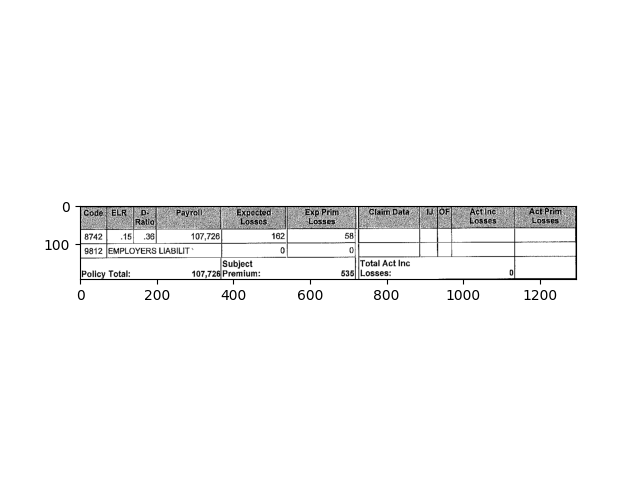

[0, 297, 672, 1046, 1421, 1670]

In [197]:
bound = boundary(im[1])

bound = cv2.cvtColor(bound, cv2.COLOR_RGB2GRAY)
bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2RGB)

bound = cv2.resize(bound, (1300,1670), interpolation = cv2.INTER_AREA)
r,c,_ = bound.shape

secs , breaks = segmentation(bound,int(r*0.03588516746))

extractsec1(det,c,breaks[1])
d = [(338, 261), (559, 297)]
img = cv2.circle(bound,d[0],5,(255,0,0),-1)
img = cv2.circle(img,d[1],5,(255,0,0),-1)
plt.imshow(img)
# bound = np.where(bound< 170 , 0,255)
# small_block,cords,hlen = same(secs[1],int(c*0.03846153846),int(c*0.02307692307))
# hlen
# plt.imshow(small_block[1][0])
# print(cords[2][0])
# bound = img

# ret, thresh = cv2.threshold(thresh, 127, 255, 0)
# b = cv2.blur(thresh , (50,1))
# c , h =  cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# bound = cv2.drawContours(img, c, -1, (0,255,0), 1)
# print(len(secs))
# extractsec1(det,c,breaks[1],bound)
# plt.imshow(bound)
plt.imshow(secs[0])
# plt.imshow(im[1])
# plt.imshow(small_block[6][3])
# hlen
# c
# len(small_block)
# len(secs)
# len(cords)
# draw(bound,sec1list,0,0,breaks[1])
# print(bound.shape)
breaks
# [(((tl1,tl2),(tr1,tr2),(br1,br2),(bl1,bl2)),text) for (((tl1,tl2),(tr1,tr2),(br1,br2),(bl1,bl2)),text) in det if tl2 < breaks[1]]

In [197]:
img[:,1200,0].shape

(1524,)

In [172]:
for (a,b,c,d),y in det:
    image = cv2.circle(bound,a,3,(0,0,255),2)
    image = cv2.circle(image,b,3,(0,255,0),2)
    image = cv2.circle(image,c,3,(255,0,0),2)
    image = cv2.circle(image,d,3,(0,0,0),2)
    
plt.imshow(image)
    

In [19]:
#     sec2 = boundary(im[page])
#     if page == 1:
#         sec1 , sec2 = segmentation(sec2)
#         LIST = detect(sec1,"sec1")
#         yy,cords= same(sec1)
#         DATERELEASED = [(307, 383), (524, 411)]
#         RISKID = [(222, 89), (711, 119)]
#         RATINGEFFECTIVE = [(901, 89), (1201, 119)]
#         RATINGLIST = []
#         RISKNAME = [(323, 119), (711, 151)]
#         RISKLIST = []
#         production_date = ""
#         for ind,x in enumerate(LIST):
#             if blockIsIn(x[0],RISKID):
#                 risk_id = x[1]
#             if blockIsIn(x[0],RATINGEFFECTIVE):
#                 RATINGLIST.append(x[1])
#             if blockIsIn(x[0],RISKNAME):
#                 RISKLIST.append(x[1])
#             if "carrier" in x[1].lower():
#                 if ":" in LIST[ind+1][1]:
#                     carrier = LIST[ind+2][1]
#                 else:
#                     carrier = LIST[ind+1][1]
#             if "policy" in x[1].lower():
#                 if ":" in LIST[ind+1][1]:
#                     policy_no = LIST[ind+2][1]
#                 else:
#                     policy_no = LIST[ind+1][1]

#         rating_effective_date = [x for x in RATINGLIST if ("/" in x)][0]
#         risk_name =  " ".join(RISKLIST)
#         state = "0-MI"
# #         print("prd",production_date)
#         production_date = ""

#         temp = {
#                                 "risk_name": risk_name,
#                                 "risk_id": risk_id,
#                                 "rating_effective_date": rating_effective_date,
#                                 "production_date": production_date,
#                                 "state": state,
#                                 "carrier": carrier,
#                                 "policy_no": policy_no,
#                                 "eff_date": "",
#                                 "exp_date": "",
#                                 "code": "",
#                                 "elr": "",
#                                 "dratio": "",
#                                 "payroll": "",
#                                 "expected_losses": "",
#                                 "exp_prim_losses": "",
#                                 "claim_data": "",
#                                 "ij": "",
#                                 "of": "",
#                                 "act_inc_losses": "",
#                                 "act_prim_losses": "",
#                                 "statecode": state,
#                                 "Policy Total": "",
#                                 "Subject Premium": "",
#                                 "Total Act Inc Losses": ""
#                             }
# #         print(temp)
# #         break

#     yy,cords = same(sec2)
#     if len(cords) > 8:
#         I = []
#         for ind,(p1,(x,y)) in enumerate(cords[:8:-1]):
#             diff = (y-p1[1])/2            
#             if x < 200 and x > 135 and diff <16:
#                 I.append(len(cords)-ind-1)
#         if len(I) > 0:
#             sec2 = cv2.line(sec2,(cords[I[-1]][1][0],0),(cords[I[0]][1][0],sec2.shape[0]),(0,0,0),3)
#         sec2 = cv2.line(sec2,(0,sec2.shape[0]),(sec2.shape[1],sec2.shape[0]),(0,0,0),3)
#         LIST = detect(sec2,"sec2")
#         found = True
#         for (box,text) in LIST:
#             if "00/00/00" in text:
#                 found = False
#         print(page,found)
#         if found:
#             break
# #         plt.imshow(sec2)
        
#         for ind,x in enumerate(LIST):
#             if "released" in x[1].lower():
#                 if ":" in LIST[ind+1][1]:
#                     production_date = LIST[ind+2][1]
#                 else:
#                     production_date = LIST[ind+1][1]
#         temp["production_date"] = production_date
#         L = []
#         for ind in range(0,len(cords)):
#             words = []    
#             v = cords[ind]
#             for x in range(len(LIST)):
#                 if isIn(LIST[x][0][1],v) and isIn(LIST[x][0][2],v):
#                     if "00/00/00" in LIST[x][1]:
#                         s = LIST[x][1].split("00/00/00")[-1]
#                         if "" != s:
#                             words.append(s)
#                 if blockIsIn(LIST[x][0],v):
#                     words.append(LIST[x][1])
#                 else:
#                     if len(words) != 0:
#                         L.append("".join(words))
#                         break
#             if len(words) == 0:
#                 L.append("")

#         lines = [[L[x+y] for y in range(12) if x+y<len(L)] for x in range(len(L)) if ('00/00/00' in L[x])] 
#         if len(lines[-1]) != 12:
#             lines[-1].append("")

#         for ind,x in enumerate(lines):
#             if '' == x[0].split("-")[-1]:
#                 lines[ind][0] += '00/00/00'
#         temp_list.extend(extractsec3(lines,temp))
#     break
    
# json["merged_amit_data_edit"] = temp_list
# json_base = []
# json_base.append(json)
# with open(sys.argv[-1]+"/"+path.split("/")[-1].split(".")[0]+'.json', 'w') as fp:
#         j.dump(json_base, fp,indent = 4)


In [17]:
det

[([[381, 16], [540, 16], [540, 48], [381, 48]], 'WORKERS'),
 ([[553, 16], [800, 16], [800, 48], [553, 48]], 'COMPENSATION'),
 ([[815, 16], [1009, 16], [1009, 48], [815, 48]], 'EXPERIENCE'),
 ([[1023, 16], [1136, 16], [1136, 48], [1023, 48]], 'RATING'),
 ([[22, 65], [114, 65], [114, 97], [22, 97]], 'NCCI'),
 ([[134, 65], [177, 65], [177, 97], [134, 97]], 'Risk'),
 ([[186, 65], [243, 65], [243, 97], [186, 97]], 'Name'),
 ([[246, 65], [249, 65], [249, 97], [246, 97]], ':'),
 ([[260, 65], [391, 65], [391, 97], [260, 97]], 'SOUTHEAST'),
 ([[400, 65], [504, 65], [504, 97], [400, 97]], 'MISSOURI'),
 ([[514, 65], [651, 65], [651, 97], [514, 97]], 'BEHAVIORAL'),
 ([[661, 65], [743, 65], [743, 97], [661, 97]], 'HEALTH'),
 ([[753, 65], [788, 65], [788, 97], [753, 97]], 'INC'),
 ([[1072, 72], [1115, 72], [1115, 92], [1072, 92]], 'Risk'),
 ([[1124, 72], [1143, 72], [1143, 92], [1124, 92]], 'ID'),
 ([[1147, 72], [1149, 72], [1149, 92], [1147, 92]], ':'),
 ([[1164, 72], [1271, 72], [1271, 92], [1164,